# Wolf vs. Wolfhound

## Implementation

Do necessary imports.

In [4]:
import os
import numpy as np
import tensorflow as tf
import cv2
import pickle
import matplotlib.pyplot as plt

from tensorflow import keras
from sklearn.model_selection import train_test_split

Settings of the experiment:

In [5]:
MONOCHROME=False
IMG_SIZE=100
EPOCHS=10

def get_color_param():
    if MONOCHROME:
        return cv2.COLOR_BGR2GRAY
    else:
        return cv2.COLOR_BGR2RGB

def get_num_color_channel():
    if MONOCHROME:
        return 1
    else:
        return 3

def get_display_img_cmap():
    if MONOCHROME:
        return "gray"
    else:
        return None

Import raw images from the `./data/` directory which contains folders for `wolves` and `dogs`. Labels: `dogs=1`, `wolves=0`. The following code snipped is used for macOS:

```python
if name == ".DS_Store":
    continue
```

This file contains meta information for folder in macOS. Under Windows and Linux this code snippet is unnecessary.

In [6]:
images = []
labels = [] # dogs = 1 # wolfs = 0

for root, dirs, files in os.walk('data'):
    for name in files:
            if name == ".DS_Store":
                continue
            file_name = os.path.join(root, name)
            labels.append(int('dogs' in file_name))
            image = cv2.imread(file_name, cv2.IMREAD_COLOR)
            image = cv2.cvtColor(image, get_color_param())
            images.append(image)

Save imported data blobs to file for later use.

In [7]:
with open('dog_wolf_files.sav', 'wb') as outfile:
    pickle.dump((labels, images), outfile)

Import image and label data from file.

In [8]:
with open('dog_wolf_files.sav', 'rb') as infile:
    labels, images = pickle.load(infile)

Create `ImageScaler` class that scales the images to the desired width and height and also
normalizing the pixel values from `[0, 255]` to `[0.0, 1.0]`

In [9]:
class ImageScaler:
    def __init__(self, width, height):
        self.width = width
        self.height = height

    def scale(self, images):
        if type(images) is list:
            image_list = [self.scale(image) for image in images]
            return image_list
        else:
            resized_image = cv2.resize(images, (self.height, self.width))
            return resized_image / 255.0


scaler = ImageScaler(width=IMG_SIZE, height=IMG_SIZE)
scaled_images = scaler.scale(images)

Split the scaled images and labels in train and testing data after shuffling the input array
to ensure a random split among classes.

In [10]:
train_images, test_images, train_labels, test_labels = train_test_split(scaled_images, labels, shuffle=True)

Reshape train and test images to match the input shape of the network.

In [11]:
train_images = tf.reshape(train_images, [-1, IMG_SIZE, IMG_SIZE, get_num_color_channel()])
test_images = tf.reshape(test_images, [-1, IMG_SIZE, IMG_SIZE, get_num_color_channel()])

Define neural network structure and compile it.

In [12]:
model = keras.Sequential([
    keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, get_num_color_channel()), padding='same'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Flatten(input_shape=(4, 4, 32)), # Depending on previous layer output
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(2, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 32)          9

Train the created model using the train images for `20` epochs.
After training the model is evaluated using the test images and labels.

In [13]:
model.fit(train_images,  np.array(train_labels), epochs=EPOCHS)
test_loss, test_acc = model.evaluate(test_images,  np.array(test_labels), verbose=2)

Epoch 1/10
47/47 [==============================] - 14s 306ms/step - loss: 0.6827 - accuracy: 0.5593

Load images of Odin and scale them to fit the requirements for inputting into the neural network.

In [14]:
odin_images = []

for root, dirs, files in os.walk('odin-pictures'):
    for name in files:
            file_name = os.path.join(root, name)
            image = cv2.imread(file_name, cv2.IMREAD_COLOR)
            image = cv2.cvtColor(image, get_color_param())
            odin_images.append(image)

odin_images = scaler.scale(odin_images)
odin_images = tf.reshape(odin_images, [-1, IMG_SIZE, IMG_SIZE, get_num_color_channel()])

Feed rescaled test images into the neural network for classification to obtain an array
of predictions. Also print the confusion matrix of the test data set.

In [15]:
predictions = model.predict(test_images)
prediction_labels = np.argmax(predictions, axis=1)
cm = tf.math.confusion_matrix(test_labels, prediction_labels)
cm

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[196,  39],
       [ 74, 191]], dtype=int32)>

Display prediction results of Odin images.

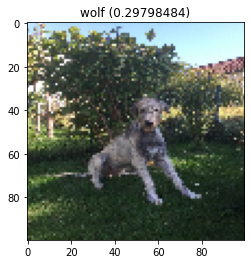

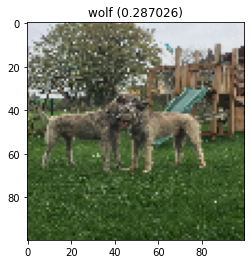

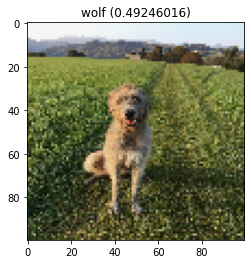

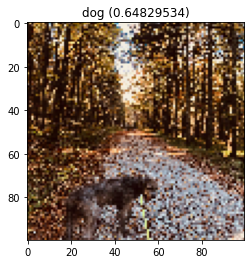

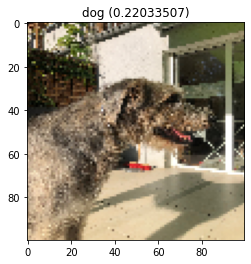

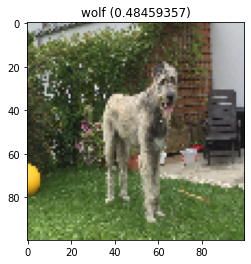

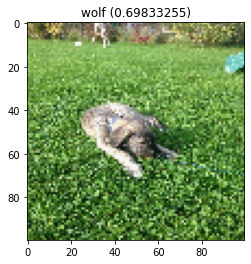

In [16]:
predictions = model.predict(odin_images)

for i, image in enumerate(odin_images):
    plt.imshow(image,cmap=get_display_img_cmap())
    if predictions[i][0] > predictions[i][1]:
        title = "wolf (" + str(predictions[i][0]) + ")"
    else:
        title = "dog (" + str(predictions[i][1]) + ")"
    plt.title(title)
    plt.show()

## Conclusion

As requested in the specification we played with different parameters. On average, our results obtained an accuracy of 70-75% in training. In our tests we also looked at the number of epochs. We were able to prove that the higher the number of epochs, the higher the accuracy. However, during evaluation it turned out that this is merely overfitting.

It turned out to be positive to increase the resolution of the images from 50x50 to 100x100. Black and white images compared to color images did not show a big difference in the accuracy of detection.

Our goal was to prove that it is difficult to distinguish an Irish Wolfhound from a wolf. We succeeded very well with this task. As can be seen in our evaluation, the model recognizes only 2 out of 7 images as a dog, the remaining 5 are classified as wolf. The result fluctuates slightly, but in all cases it is difficult to determine a clear class. Despite the classification of my dog as wolf, I am quite sure that I have a dog at my home ;-)